STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

  n_iter_i = _check_optimize_result(



Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix:
 [[915 118]
 [182 192]]
ROC AUC Score: 0.8318

Random Forest Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407

Confusion Matrix:
 [[931 102]
 [187 187]]
ROC AUC Score: 0.8212

CatBoost Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      

<Figure size 800x600 with 0 Axes>

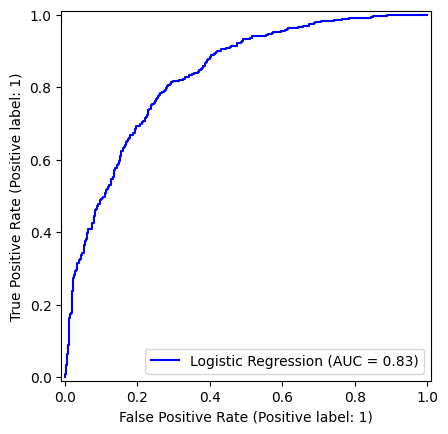

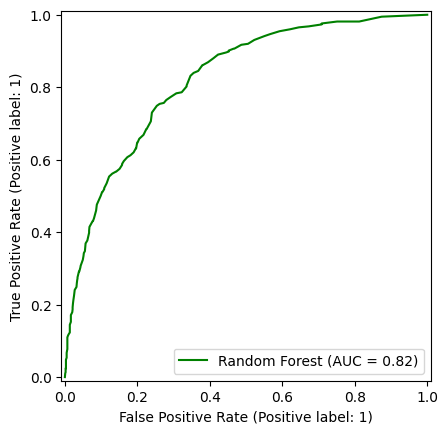

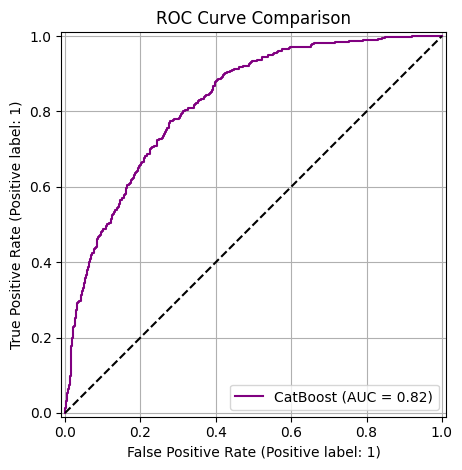

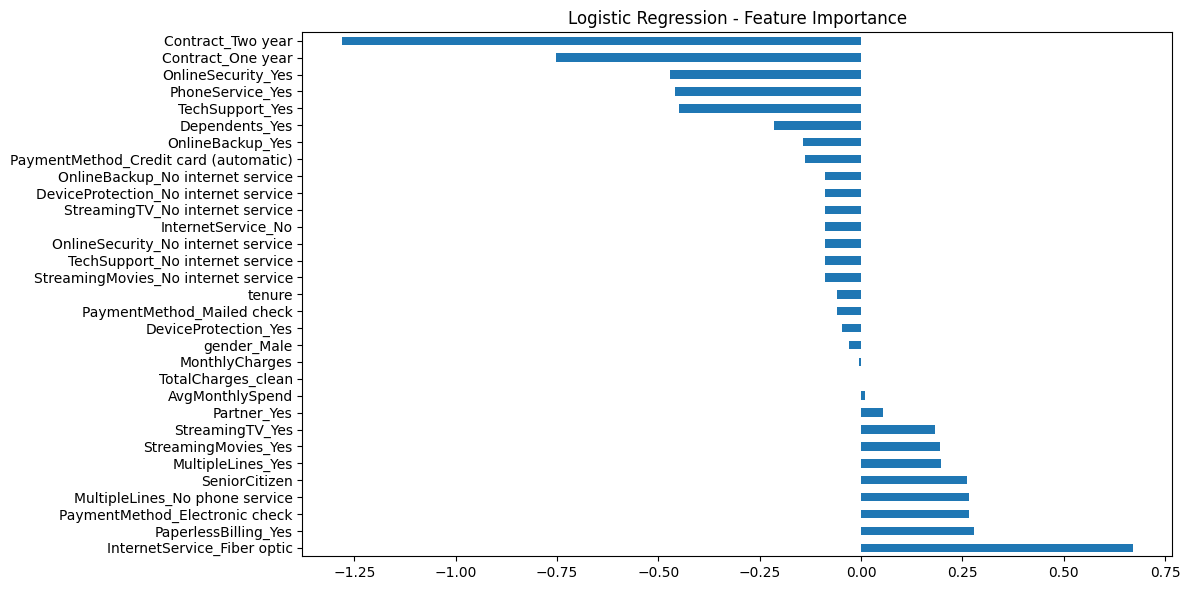

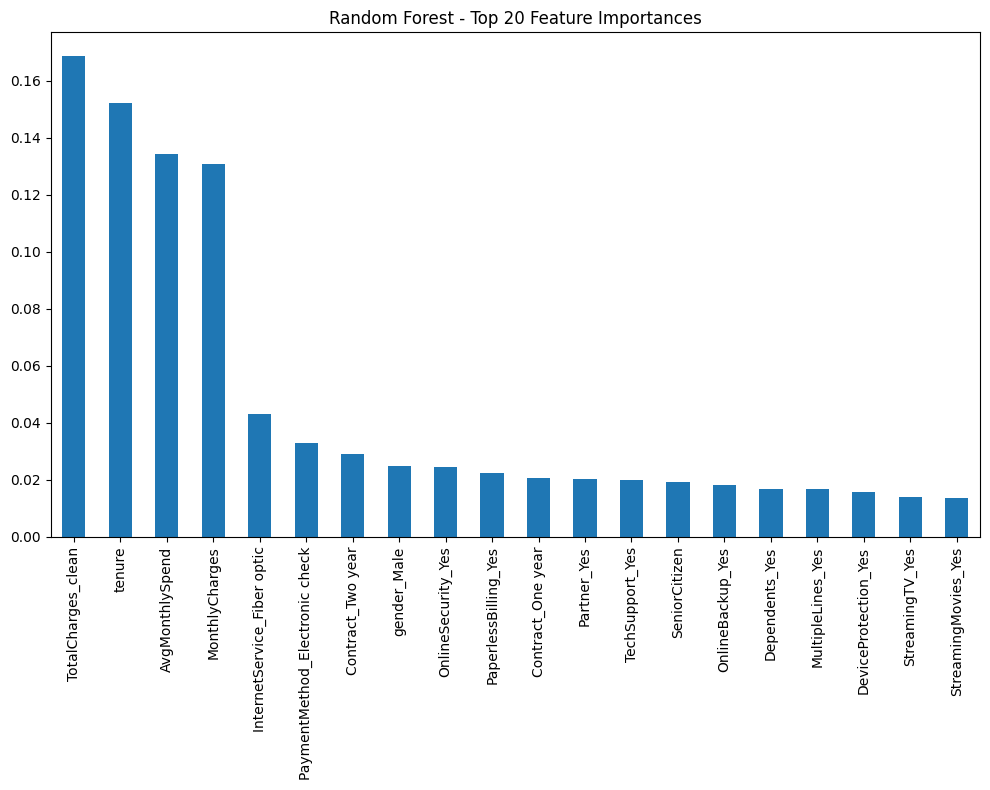

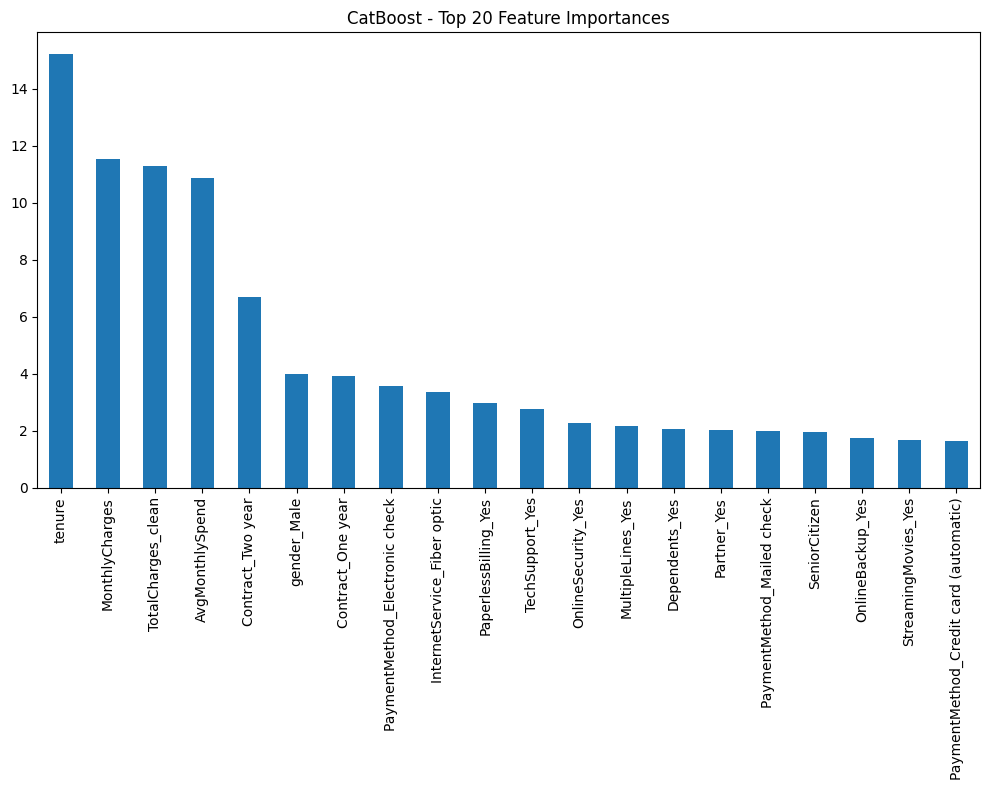

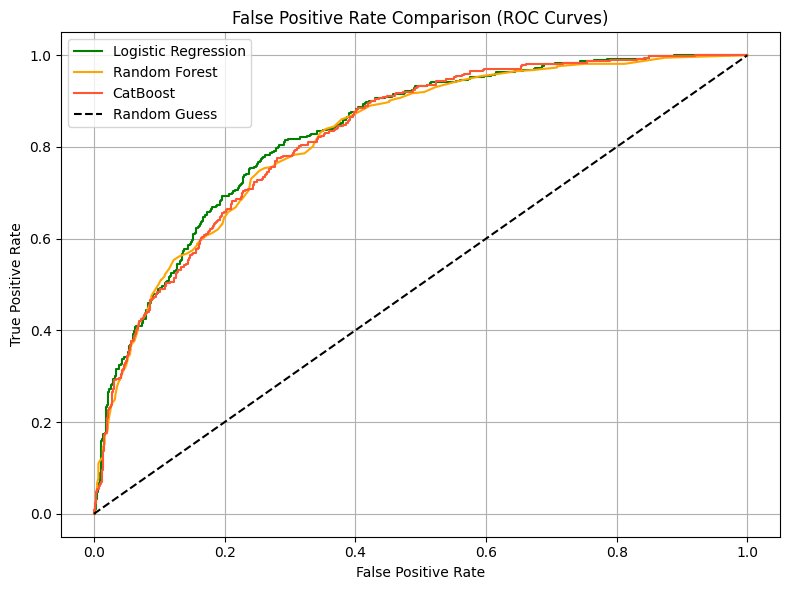


Model Performance Comparison:
metrics_df
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression    0.7868     0.6194  0.5134    0.5614   0.8318
Random Forest          0.7946     0.6471  0.5000    0.5641   0.8212
CatBoost               0.7861     0.6229  0.4947    0.5514   0.8243


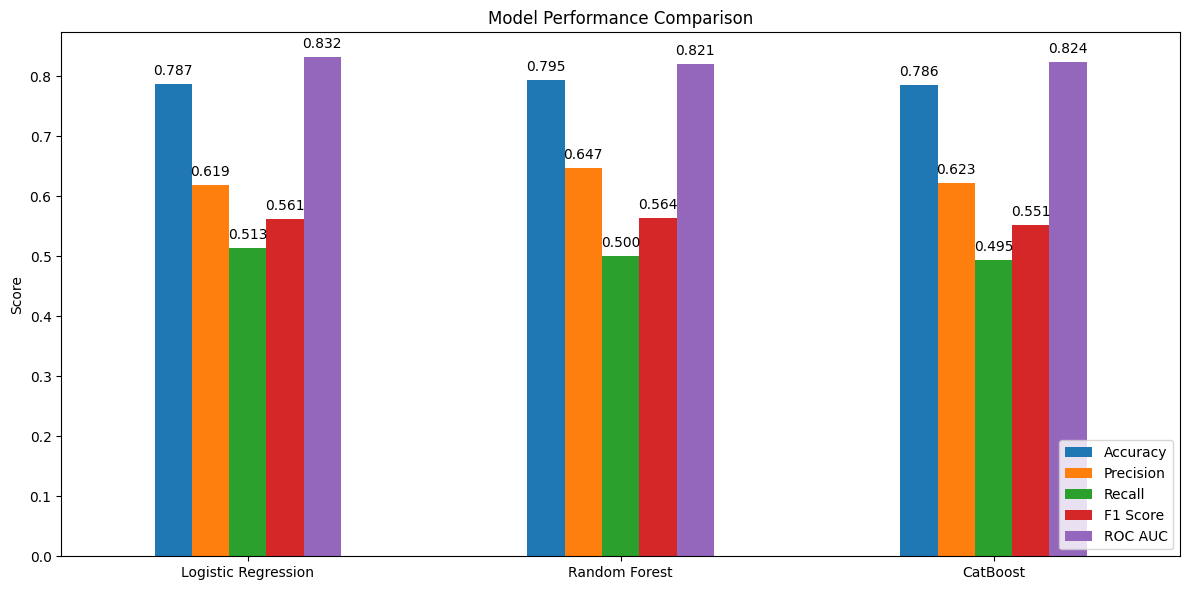

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

from catboost import CatBoostClassifier

# Load cleaned dataset
df = pd.read_csv('../data/telco_churn_cleaned.csv')

# Drop unused or redundant columns
df.drop(columns=['customerID', 'TotalCharges', 'Churn'], inplace=True)
df.dropna(inplace=True)  # Drop rows with any missing values

# Encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Define features and target
X = df_encoded.drop('ChurnFlag', axis=1)
y = df_encoded['ChurnFlag']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# CatBoost Classifier
cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)
cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_test)
y_proba_cb = cb.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n{model_name} Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("ROC AUC Score:", round(roc_auc_score(y_true, y_proba), 4))

# Evaluate all models
evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")
evaluate_model(y_test, y_pred_cb, y_proba_cb, "CatBoost")

# ROC Curve Plot
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="Logistic Regression", color='blue')
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest", color='green')
RocCurveDisplay.from_predictions(y_test, y_proba_cb, name="CatBoost", color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance from Logistic Regression
coefficients = pd.Series(lr.coef_[0], index=X.columns)
coefficients.sort_values(ascending=False).plot(kind='barh', figsize=(12, 6))
plt.title("Logistic Regression - Feature Importance")
plt.tight_layout()
plt.show()

# Feature Importance from Random Forest
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='bar', figsize=(10, 8))
plt.title("Random Forest - Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Feature Importance from CatBoost
feature_importance = pd.Series(cb.get_feature_importance(), index=X.columns)
feature_importance.nlargest(20).plot(kind='bar', figsize=(10, 8))
plt.title("CatBoost - Top 20 Feature Importances")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score

# Compute ROC Curve (FPR & TPR) for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_proba_cb)

# Plot FPR comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression", color="green")
plt.plot(fpr_rf, tpr_rf, label="Random Forest", color="orange")
plt.plot(fpr_cb, tpr_cb, label="CatBoost", color="#FF5733")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("False Positive Rate Comparison (ROC Curves)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create comparison metrics table
def get_model_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

# Collect metrics for each model
metrics = {
    'Logistic Regression': get_model_metrics(y_test, y_pred_lr, y_proba_lr),
    'Random Forest': get_model_metrics(y_test, y_pred_rf, y_proba_rf),
    'CatBoost': get_model_metrics(y_test, y_pred_cb, y_proba_cb)
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics).T.round(4)
print("\nModel Performance Comparison:")
print('metrics_df')
print(metrics_df)

# Optional: Plot comparison table as bar chart
ax = metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position: center of the bar
        height + 0.01,                  # Y position: just above the bar
        f'{height:.3f}',                # Text label with 3 decimals
        ha='center',                   # Horizontal alignment
        va='bottom'                    # Vertical alignment
    )
plt.tight_layout()
plt.show()


In [30]:
# Save model performance metrics to CSV
metrics_df.to_csv("../data/model_performance_comparison.csv", index=True)

# Save confusion matrices
conf_matrix_df = pd.DataFrame({
    'Model': ['Logistic Regression']*4 + ['Random Forest']*4 + ['CatBoost']*4,
    'Metric': ['TN', 'FP', 'FN', 'TP']*3,
    'Value': [
        confusion_matrix(y_test, y_pred_lr).ravel()[0],
        confusion_matrix(y_test, y_pred_lr).ravel()[1],
        confusion_matrix(y_test, y_pred_lr).ravel()[2],
        confusion_matrix(y_test, y_pred_lr).ravel()[3],
        
        confusion_matrix(y_test, y_pred_rf).ravel()[0],
        confusion_matrix(y_test, y_pred_rf).ravel()[1],
        confusion_matrix(y_test, y_pred_rf).ravel()[2],
        confusion_matrix(y_test, y_pred_rf).ravel()[3],
        
        confusion_matrix(y_test, y_pred_cb).ravel()[0],
        confusion_matrix(y_test, y_pred_cb).ravel()[1],
        confusion_matrix(y_test, y_pred_cb).ravel()[2],
        confusion_matrix(y_test, y_pred_cb).ravel()[3],
    ]
})
conf_matrix_df.to_csv("../data/confusion_matrices.csv", index=False)

# Determine the maximum length among all FPR/TPR arrays
max_len = max(len(fpr_lr), len(fpr_rf), len(fpr_cb))

# Function to pad an array with NaNs to match the max length
def pad(arr, length=max_len):
    return np.pad(arr, (0, length - len(arr)), constant_values=np.nan)

# Create aligned ROC curve DataFrame
roc_df = pd.DataFrame({
    'FPR_LR': pad(fpr_lr),
    'TPR_LR': pad(tpr_lr),
    'FPR_RF': pad(fpr_rf),
    'TPR_RF': pad(tpr_rf),
    'FPR_CB': pad(fpr_cb),
    'TPR_CB': pad(tpr_cb)
})

# Export to CSV
roc_df.to_csv("../data/roc_curve_data.csv", index=False)



In [31]:
# Create long format ROC dataframe for Tableau
roc_combined = pd.DataFrame({
    'FPR': np.concatenate([fpr_lr, fpr_rf, fpr_cb]),
    'TPR': np.concatenate([tpr_lr, tpr_rf, tpr_cb]),
    'Model': (['Logistic Regression'] * len(fpr_lr)) +
             (['Random Forest'] * len(fpr_rf)) +
             (['CatBoost'] * len(fpr_cb))
})

# Save to CSV
roc_combined.to_csv("../data/roc_long_for_tableau.csv", index=False)
